In [1]:
from datetime import date, timedelta
import datetime as dt
from dateutil.parser import parse
from typing import Sequence
from pathlib import Path
import sh 
from PIL import Image
# import cv2


import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm         as cm
import matplotlib.colors     as mcolors
import matplotlib.patches    as mpatches
import matplotlib.transforms as mtransforms
import matplotlib.dates      as mdates

from netCDF4 import Dataset
import geomagdata as gi

from pylab import *
import pywt 

import scipy.io        as scio
import scipy.constants as const
from   scipy.fftpack   import fft
from   scipy.stats     import chi2

In [2]:
def FFT(Fs, data):
    L = len(data)

    N = np.power(2, np.ceil(np.log2(L)))
    N = int(N)

    FFT_y = np.abs(fft(data,N))/L*2
    Fre   = np.arange(int(N/2))*Fs/N
    FFT_y = FFT_y[range(int(N/2))]
    
    return Fre, FFT_y

# 计算lags阶以内的自相关系数，返回lags个值，将序列均值、标准差视为不变
def autocorrelation(x,lags):
    n = len(x)
    x = np.array(x)
    variance = x.var()
    x = x-x.mean()
    result = np.correlate(x, x, mode = 'full')[-n+1:-n+lags+1]/\
    (variance*(np.arange(n-1,n-1-lags,-1)))
    return result




In [3]:
def format_func(x, 
                pos=None
               ):
    x = mdates.num2date(x)
    
    if x.hour == 0:
        fmt = '%H\n%b %d'
    else:
        fmt = '%H'
    label = x.strftime(fmt)
    
    
    return label

def add_right_cax(ax, pad, width):
    '''
    在一个ax右边追加与之等高的cax.
    pad是cax与ax的间距,width是cax的宽度.
    '''
    axpos = ax.get_position()
    caxpos = mtransforms.Bbox.from_extents(
        axpos.x1 + pad,
        axpos.y0,
        axpos.x1 + pad + width,
        axpos.y1
    )
    cax = ax.figure.add_axes(caxpos)

    return cax

In [4]:
def getAEindex_daily(date = dt.datetime(2022, 8, 31),
                     AEdir = Path(f'/run/media/echoo/TOSHIBA EXT/space_weather/AEindex/')
                    ):
    yyyymm = date.strftime('%Y%m')
    yyyymmdd = date.strftime('%Y%m%d')

    # https://wdc.kugi.kyoto-u.ac.jp/ae_realtime/index.html
    webpage = Path(f'https://wdc.kugi.kyoto-u.ac.jp/ae_realtime')
    AEonline = webpage/f'{yyyymm}'/f'rtae_{yyyymmdd}.png'
    AEfile = AEdir/f'rtae_{yyyymmdd}.png'
    
    if Path.is_file(AEfile):
        pass
    else:
        sh.touch(AEfile)
        sh.curl('-o', AEfile, AEonline)

    AEimage = Image.open(AEfile)
#     AEimage
    
    pixels = np.array(AEimage)[::-1]
    vspan = range(82, 196)
    hspan = range(80, 650)
    rpixel = 0
    wpixel = 255
    graypixel = 187
    
    scale = 2000/len(vspan)       # units: nT
    
    AEpixels = pixels[vspan][:,hspan][:,:,rpixel]

#     AEpixels = np.where(AEpixels == wpixel   , np.NaN, AEpixels)
#     AEpixels = np.where(AEpixels == graypixel, np.NaN, AEpixels)
#     plt.contour(AEpixels)
#     AEpixels.shape
    
    AEpixels = np.where(AEpixels == wpixel, 
                        None, 
                        AEpixels
                       )
    AEpixels = np.where(AEpixels == graypixel, 
                        None, 
                        AEpixels
                       )
    
    tlength = AEpixels.shape[1]
    AEedge = np.zeros(tlength)
#     AEedge.shape
    for  t, plh in enumerate(AEpixels[0][:]):
        for v, plv in enumerate(AEpixels[::-1, t]):
            if plv is not None :
                AEedge[t] = (len(vspan)-v) * scale
    #             print(h, AE[h])
                break
            AEedge[t] = np.NaN
            continue
    
    AEedge = np.where(AEedge > 1500, np.NaN, AEedge)
#     plt.plot(AEedge)
#     plt.ylim(0,2000)


    start = date
    end   = start + timedelta(days = 1)
    tspan = pd.date_range(start = start, 
                          periods = 1440, 
                          freq = 'T'         # frequency: 1 min
                         )    

    tseq = np.arange( len(tspan) ) * len(hspan) / len(tspan)    # for interp
    AE_interp = np.interp(tseq, 
                          np.arange(tlength), 
                          AEedge, 
                          left = True, 
                          right = True
                         )

    data = {'time':tspan,
            'AE'  :AE_interp
           }
    AEdframe = pd.DataFrame(data)
    AEdframe['AE'] = AEdframe['AE'].interpolate()
    return AEdframe

# AE = getAEindex_daily(datetime(2022,8,27), AEdir)

In [5]:
def plotF107(ax, indices):
#     ticks = [0, 12]
#     ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
#     # ax.xaxis.set_minor_locator(mdates.Locator())
#     ax.xaxis.set_major_formatter(format_func)
    ax.set_xticks([])

    colors     = ['xkcd:pastel pink', 'xkcd:pinkish red']
    thresholds = [120]
    control    = [0] + thresholds + [1000]
    thresholds_spans = [i for i in zip(control, control[1:])]
    dates = indices.index
    
#     ax.set_xlim(dates[0], dates[-1])
    ax.set_ylim(90, 240)
    ax.set_yticks(np.arange(90, 270, 30))

    for color , thresholds_span in zip(colors, thresholds_spans):
        low, high = thresholds_span
        line_data = np.ma.masked_array(indices['f107s'].values, 
                                       mask = (indices['f107s'].values<low)|(indices['f107s'].values>high)
                                      )
        ax.plot(dates, 
                line_data, 
                color, 
                marker='.', 
                markersize = 3.5,
                linewidth = 0
               )

    for threshold in thresholds:
        ax.axhline(threshold,
                   linestyle = '--',
                   color = 'grey',
                   alpha = 0.3,
                   zorder = -100
                  )
        
#     ax.set_ylabel("F10.7 (sfu)")
    ax.set_title('a) F10.7 (sfu)', loc = 'left')
#     ax.set_xlabel("time (LT)")
    # ax.grid(True)

    # fig.savefig('2015.png', bbox_inches='tight')

#     plt.show()

In [6]:
def plotAE(ax, AEindex):
#     ticks = [0,12]
#     ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
#     # ax.xaxis.set_minor_locator(mdates.Locator())
#     ax.xaxis.set_major_formatter(format_func)
    ax.set_xticks([])

    colors = ['mistyrose', 'crimson']
    thresholds = [500]
    control    = [0] + thresholds + [2000]
    thresholds_spans = [i for i in zip(control, control[1:])]
    
    ax.set_ylim(0,1500)
    ax.set_yticks(np.arange(0,2000,500))

    for color , thresholds_span in zip(colors, thresholds_spans):
        low, high = thresholds_span
        AEplt     = AEindex['AE'].values
        tplt      = AEindex['time']
        line_data = np.ma.masked_array(AEplt, 
                                       mask = (AEplt<low)|(AEplt>high)
                                      )
        ax.plot(tplt, 
                 line_data, 
                 color, 
                 marker = ',',
                 linewidth = 0.5
                )

    for threshold in thresholds:
        ax.axhline(threshold,
                    linestyle = '--',
                    color = 'grey',
                    alpha = 0.3,
                    zorder = -100
                  )
#     ax.set_ylabel("AE index (nT)")
    ax.set_title('b) AE index (nT)', loc = 'left')
#     ax.set_xlabel("time (LT)")
    # ax.grid(True)

    # fig.savefig('2015.png', bbox_inches='tight')

#     plt.show()


In [7]:
def plotKp(ax, indices):
    dates = indices.index
    
    ticks = [0, 12]
    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    # ax.xaxis.set_minor_locator(mdates.Locator())
    ax.xaxis.set_major_formatter(format_func)
    # inds['Ap'].plot(ax=ax)
    
    ax.set_ylim(0, 9)
    ax.set_yticks(np.arange(1,10,2))
    ax.bar(dates, 
            indices['Kp'].values, 
            width = 0.1, 
            color = np.where(indices['Kp']>3, 
                             'red', 
                             'lavenderblush'
                            )
    #         color = np.where(indices['Kp']>3, 'royalblue', 'aliceblue'),
    #         edgecolor = 'aliceblue',
    #         color = 'dodgerblue'
           )
    # indices['Kp'].plot(ax = ax, marker = '.')  # , marker='.'
    ax.axhline(3,
               linestyle = '--',
               color = 'grey',
               alpha = 0.3,
               zorder = -100
             )
#     ax.set_ylabel("Kp index")
    ax.set_title('c) Kp index', loc = 'left')
    ax.set_xlabel("time (UT)")
    # ax.grid(True)

    # fig.savefig('2015.png', bbox_inches='tight')

#     plt.show()

In [8]:
# period = 86400    # test
def plot_TECs_at_station(ax, 
                         sTEC,
                         zeniths,
                         time_system = 'UTC'
                        ):
    
    colors = ['orangered',
#               'crimson',
              'gold', 
              'aquamarine', 
#               'mediumaquamarine',
              'dodgerblue',
              'greenyellow',
#               'darkviolet'
             ]
    
    eleDegrees = 90 - np.degrees(zeniths)
    
    for i, sv in enumerate(sTEC.sv):
        ax.plot(sTEC.time.values[::10], 
                sTEC.sel(sv = sv)[::10],
                color = colors[i],
#                 marker = ',',
                linestyle = "-", 
                linewidth = '0.8',
                label = f'{sv.values} ' 
                        f'{eleDegrees.sel(sv = sv).values:5.2f}' 
                        f'\N{DEGREE SIGN}'
               )
    
#     legend(labelcolor = 'linecolor')
    legend()
    
#     ticks = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
#     ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
#     ax.xaxis.set_minor_locator(mdates.HourLocator())
#     ax.xaxis.set_major_formatter(format_func)
    
    ax.set_xlabel(f'{time_system} time')
    ax.set_ylabel(f'TEC / {sTEC.units}')
    
#     plt.title(f'{sTEC.observer.values} {sTEC.name}')
#     plt.savefig(f'{sTEC.observer.values}_{sTEC.name}.png',
#                 bbox_inches='tight', 
#                )

# plot_TECs_at_station(nc.sTEC_smth.sel(observer = 'GSLZ'),
#                      nc.zenith.sel(observer = 'GSLZ')
#                     )             # test

In [9]:
def plotTECnorm(ax, time, data):
    ax.plot(time, data, marker = ',', linewidth = 0)
    ax.set_xlabel('time (UT)')
#     ax.set_ylabel('vTEC (TECU)')
    ax.set_title('d) vTEC (TECU)', loc = 'left')

#     ax.set_title(f'a) {data.observer.values} {data.observer.sv.values}')
#     ticks = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
#     f_ax1.xaxis.set_major_locator(mdates.HourLocator(ticks))
#     f_ax1.xaxis.set_minor_locator(mdates.HourLocator())
#     f_ax1.xaxis.set_major_formatter(format_func)
#     f_ax1.set_xlim(time[0], time[-1])

In [10]:
def plotCWT(ax, time, periods, coimatr):
    

    levels = np.arange(0, 20, 1)
    cmap = plt.get_cmap('GnBu_r')
    cax = add_right_cax(ax, pad = 0.02, width = 0.02)
    im = ax.contourf(time, 
                        periods/60/60, 
                        np.abs(cwtmatr), 
                        levels, 
                        cmap = cmap, 
                        alpha = 0.8)

    # cbar = fig.colorbar(im, cax=cax, extend = 'both')

    ax.contourf(time, 
                   periods/60/60,
                   coimatr, 
                   alpha = 0.7, 
                   cmap = cmap)
    ax.invert_yaxis()
    # f_ax2.set_yscale('log', base =2)
    ax.set_xlabel(u'time (UT)')
    ax.set_ylabel('periods (hour)')
    ax.set_title('VTEC Wavelet Transform', loc = 'left')

    ax.xaxis.set_major_locator(mdates.HourLocator(ticks))
    ax.xaxis.set_minor_locator(mdates.HourLocator())
    ax.xaxis.set_major_formatter(format_func)


# plt.savefig(f"waveletTransform_"
#             f"{obs['date']}_"
#             f"{data.observer.values}_{data.observer.sv.values}.png", 
#             bbox_inches='tight', 
#             dpi = 500
#            )
# plt.show()

In [11]:
start = dt.datetime(2022, 8, 22)
end   = dt.datetime(2022, 8, 29)
timezone = 8

dates = pd.date_range(start, end, freq="3H")

try:
    indices = gi.get_indices(dates, smoothdays = 3)
except ConnectionError as e:
    pytest.skip(f"possible timeout error {e}")

pasttime = dt.datetime(2017, 1, 1)
if indices["resolution"][0] == "d":
    pasttime += timedelta(hours=1, minutes=30)

# indices.index += timedelta(hours = timezone)

In [12]:
AEdir = Path(f'/run/media/echoo/TOSHIBA EXT/space_weather/AEindex/')

is_first_day = True
for date in pd.date_range(start, 
                          end-timedelta(days=1),
                          freq = '1D'
                         ):
    AE = getAEindex_daily(date, AEdir)
#     plt.ylim(0,2000)
#     plt.plot(AE['AE'])
    if is_first_day:
        AEindex = AE
    else:
        AEindex = pd.concat([AEindex, AE], 
                            axis = 0 
                           )
    is_first_day = False

# AEindex['time'] += timedelta(hours = timezone) 

In [13]:
obs = {}

event_date       = datetime.date(2022,9,5).strftime('%Y_%m_%d')
epicenter        = 'Luding'

In [14]:

# src_dir  = Path(f'/run/media/echoo/TOSHIBA EXT/GNSS/{event_date}_{epicenter}')

# is_first_day = True
# for date in pd.date_range(start, 
#                           end-timedelta(days=1), 
#                           freq="D"
#                          ):
#     obs['year']      = date.strftime('%y')
#     obs['doy']       = date.strftime('%j')
#     obs['samp_rate'] = '01s'

#     # src_dir  = Path(f"/run/media/echoo/TOSHIBA EXT")

#     TEC_dir  = src_dir/obs['doy']/'TEC'
#     TEC_file = f"TEC_{obs['doy']}_{obs['samp_rate']}_{obs['year']}.nc"
#     TEC_path = TEC_dir/TEC_file
#     nc = xr.open_dataset(TEC_path)
#     nc.coords['time'] = nc.time + np.timedelta64(timezone, 'h')
#     nc.attrs['time_sysm'] = 'BJT'

    
#     sTEC   = nc.sTEC_smth.sel(observer = 'GSLZ', sv = 'C01').dropna(dim = 'time') 
#     zenith = nc.zenith.sel(observer = 'GSLZ', sv = 'C01')
#     vTECdaily    = sTEC * np.cos(zenith)

#     if is_first_day:
#         vTEC     = vTECdaily
#     else:
#         vTEC      = xr.concat([vTEC  , vTECdaily]    , dim = 'time')
#     is_first_day = False
    
# data         = vTEC
# time         = vTEC.time
# t            = np.arange(1,len(time)+1,1)
# std          = data.std()

# p            = np.polyfit(t, data, 1)
# trend        = np.polyval(p, t)
# dtrend       = data - trend
# norm_daily   = dtrend / std

# # variance     = std ** 2
# # variance     = variance.values

# # data_norm    = data_notrend / std
# # nc = xr.open_dataset(TEC_path)
# # nc.coords['time'] = nc.time + np.timedelta64(timezone, 'h')
# # nc.attrs['time_sysm'] = 'BJT'

# # plot_TECs_at_station(nc.sTEC_smth.sel(observer = 'GSLZ'),
# #                      nc.zenith.sel(observer = 'GSLZ'),
# #                      nc.time_sysm
# #                     )             # test

In [15]:
# sTEC   = nc.sTEC_smth.sel(observer = 'GSLZ', sv = 'C01').dropna(dim = 'time') 
# zenith = nc.zenith.sel(observer = 'GSLZ', sv = 'C01')
# vTEC   = sTEC * np.cos(zenith)

In [16]:
# vTEC

In [17]:
# data         = vTEC
# time         = vTEC.time
# t            = np.arange(1,len(time)+1,1)

# p            = np.polyfit(t, data, 2)
# data_trend   = np.polyval(p, t)
# data_notrend = data - data_trend

# std          = data.std()
# variance     = std ** 2
# variance     = variance.values

# data_norm    = data_notrend / std

# wavelet = 'cmor1200-0.000075'


In [18]:
# data_norm

In [19]:
# fc              = 2**(-9)
# fband           = 2**(6)
# # wavelet         = f'cmor{fband}-{fc}'
# wavelet         = 'cgau8'
# drelation       = 2.32

# sampling_period = 1.0 / 15 / 60            # units: 15min
# sampling_rate   = 1.0 / sampling_period    # units: 1/15min
# totalfreqc      = 256

# # fc              = pywt.central_frequency(wavelet)
# # cparam          = 2 * fc * totalscale
# # scales          = cparam / np.arange(totalscale, 0, -1)
# max_power       = -11
# min_power       = -13

# interval        = (max_power - min_power) / totalfreqc 
# fourier_freqces = 2 ** np.arange(min_power, max_power, interval) 
# scales          = pywt.frequency2scale(wavelet, fourier_freqces)

# [cwtmatr, frequencies] = pywt.cwt(data_norm, 
#                                   scales, 
#                                   wavelet, 
#                                   1.0, 
#                                   'fft'
#                                  )

# periods = np.power(frequencies, -1)

# L = len(data_norm)
# coi_scale = scales[-1]-abs(t-L/2.0)+ scales[0]
# coimatr = np.zeros(shape = cwtmatr.shape)

# for n in range(coimatr.shape[0]):
#     scale = scales[n]
#     t1 = np.floor(scale*np.sqrt(2.0))
#     t2 = np.ceil(L - scale*np.sqrt(2.0))
#     coimatr[n][int(t1):int(t2)] = np.nan 
# #     cwtmatr[n][:int(t1)] = np.nan
# #     cwtmatr[n][int(t2):] = np.nan
    

In [20]:
# fig, ax = plt.subplots(2, 1)
# plotTECnorm(ax[0], time, data)

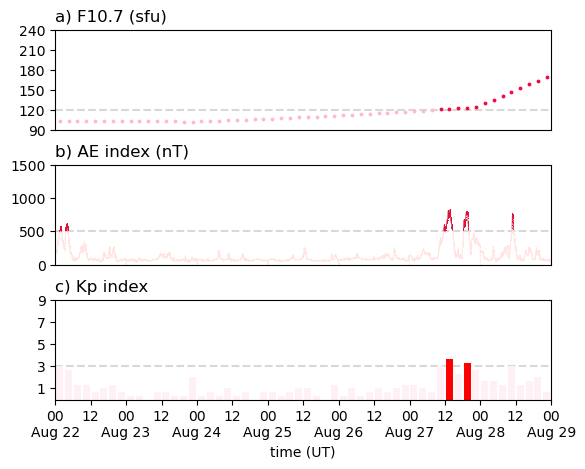

In [21]:
save_dir  = Path(f'/home/echoo/echoo/mycode/PLOT/{event_date}_{epicenter}')

fig, ax = plt.subplots(3, 1)
fig.subplots_adjust(hspace = 0.35)

xstart = AEindex['time'].values[0]
xend   = AEindex['time'].values[-1] + np.timedelta64(1, 'm')
plotF107(ax[0], 
         indices
        )
ax[0].set_xlim(xstart, xend)

plotAE(ax[1], 
       AEindex
      )
ax[1].set_xlim(xstart, xend)

plotKp(ax[2], 
       indices
      )
ax[2].set_xlim(xstart, xend)

fig.align_ylabels()

savefile  = save_dir/f'space_effect_{start.month}-{start.day}_{end.month}-{end.day-1}_{epicenter}.png'
fig.savefig(savefile, 
            bbox_inches = 'tight', 
            dpi = 600
           )

# fig.clf()
# plt.clf()
# plt.close('all')
# plt.close(fig)
# # gc.collect()
